In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

In [2]:
# Load and preprocess CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [3]:

train_images, test_images = train_images / 255.0, test_images / 255.0
train_labels, test_labels = to_categorical(train_labels, num_classes=10), to_categorical(test_labels, num_classes=10)

In [4]:
def inception_module(prev_layer, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    conv1x1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(prev_layer)

    conv3x3_reduce = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(prev_layer)
    conv3x3 = layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv3x3_reduce)

    conv5x5_reduce = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(prev_layer)
    conv5x5 = layers.Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv5x5_reduce)

    pool_proj = layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(prev_layer)

    inception = layers.concatenate([conv1x1, conv3x3, conv5x5, pool_proj], axis=-1)

    return inception

In [5]:
# Define GoogleNet model with corrected auxiliary classifiers placement
def create_googlenet_model():
    input_layer = layers.Input(shape=(32, 32, 3))

    conv1_7x7_s2 = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    pool1_3x3_s2 = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(conv1_7x7_s2)

    conv2_3x3_reduce = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(pool1_3x3_s2)
    conv2_3x3 = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(conv2_3x3_reduce)
    pool2_3x3_s2 = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(conv2_3x3)

    inception_3a = inception_module(pool2_3x3_s2, 64, 96, 128, 16, 32, 32)
    aux_classifier_1 = layers.GlobalAveragePooling2D()(inception_3a)
    aux_classifier_1 = layers.Dense(10, activation='softmax', name='aux_classifier_1')(aux_classifier_1)

    inception_3b = inception_module(inception_3a, 128, 128, 192, 32, 96, 64)
    pool3_3x3_s2 = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(inception_3b)

    inception_4a = inception_module(pool3_3x3_s2, 192, 96, 208, 16, 48, 64)
    inception_4b = inception_module(inception_4a, 160, 112, 224, 24, 64, 64)
    inception_4c = inception_module(inception_4b, 128, 128, 256, 24, 64, 64)
    inception_4d = inception_module(inception_4c, 112, 144, 288, 32, 64, 64)
    inception_4e = inception_module(inception_4d, 256, 160, 320, 32, 128, 128)
    pool4_3x3_s2 = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(inception_4e)

    aux_classifier_2 = inception_module(pool4_3x3_s2, 256, 160, 320, 32, 128, 128)
    aux_classifier_2 = layers.GlobalAveragePooling2D()(aux_classifier_2)
    aux_classifier_2 = layers.Dense(10, activation='softmax', name='aux_classifier_2')(aux_classifier_2)

    inception_5a = inception_module(pool4_3x3_s2, 256, 160, 320, 32, 128, 128)
    inception_5b = inception_module(inception_5a, 384, 192, 384, 48, 128, 128)

    aux_classifier_3 = inception_module(inception_4a, 192, 96, 208, 16, 48, 64)
    aux_classifier_3 = layers.GlobalAveragePooling2D()(aux_classifier_3)
    aux_classifier_3 = layers.Dense(10, activation='softmax', name='aux_classifier_3')(aux_classifier_3)

    avg_pool = layers.GlobalAveragePooling2D()(inception_5b)
    dropout = layers.Dropout(0.4)(avg_pool)
    output_layer = layers.Dense(10, activation='softmax', name='main_classifier')(dropout)

    model = models.Model(inputs=input_layer, outputs=[output_layer, aux_classifier_1, aux_classifier_2, aux_classifier_3])

    return model

In [6]:
# Create and compile the model
model = create_googlenet_model()
model.compile(optimizer='adam', loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'],
              metrics=['accuracy'])

In [7]:
# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 8, 8, 64)             0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             4160      ['max_pooling2d[0][0]']   

In [8]:
# Train the model
model.fit(train_images, [train_labels, train_labels, train_labels, train_labels], 
          epochs=20, 
          validation_data=(test_images, [test_labels, test_labels, test_labels, test_labels])
          )

Epoch 1/20
1563/1563 [==============================] - 321s 189ms/step - loss: 7.1749 - main_classifier_loss: 1.8440 - aux_classifier_1_loss: 1.7409 - aux_classifier_2_loss: 1.8215 - aux_classifier_3_loss: 1.7685 - main_classifier_accuracy: 0.2856 - aux_classifier_1_accuracy: 0.3388 - aux_classifier_2_accuracy: 0.2958 - aux_classifier_3_accuracy: 0.3256 - val_loss: 6.0666 - val_main_classifier_loss: 1.5519 - val_aux_classifier_1_loss: 1.4844 - val_aux_classifier_2_loss: 1.5393 - val_aux_classifier_3_loss: 1.4911 - val_main_classifier_accuracy: 0.4307 - val_aux_classifier_1_accuracy: 0.4553 - val_aux_classifier_2_accuracy: 0.4363 - val_aux_classifier_3_accuracy: 0.4510
Epoch 2/20
1563/1563 [==============================] - 300s 192ms/step - loss: 5.7134 - main_classifier_loss: 1.4716 - aux_classifier_1_loss: 1.3950 - aux_classifier_2_loss: 1.4443 - aux_classifier_3_loss: 1.4026 - main_classifier_accuracy: 0.4651 - aux_classifier_1_accuracy: 0.4874 - aux_classifier_2_accuracy: 0.4730 -

In [9]:
# Evaluate the model
test_loss, test_main_classifier_loss, test_aux1_loss, test_aux2_loss, test_aux3_loss, test_main_classifier_acc, test_aux1_acc, test_aux2_acc, test_aux3_acc = model.evaluate(test_images, [test_labels, test_labels, test_labels, test_labels])
print(f"Main Classifier Test Accuracy: {test_main_classifier_acc}")
print(f"Auxiliary Classifier 1 Test Accuracy: {test_aux1_acc}")
print(f"Auxiliary Classifier 2 Test Accuracy: {test_aux2_acc}")
print(f"Auxiliary Classifier 3 Test Accuracy: {test_aux3_acc}")

313/313 [==============================] - 9s 27ms/step - loss: 5.2742 - main_classifier_loss: 1.3416 - aux_classifier_1_loss: 1.1531 - aux_classifier_2_loss: 1.3372 - aux_classifier_3_loss: 1.4422 - main_classifier_accuracy: 0.6531 - aux_classifier_1_accuracy: 0.6600 - aux_classifier_2_accuracy: 0.6567 - aux_classifier_3_accuracy: 0.6583
Main Classifier Test Accuracy: 0.6531000137329102
Auxiliary Classifier 1 Test Accuracy: 0.6600000262260437
Auxiliary Classifier 2 Test Accuracy: 0.6567000150680542
Auxiliary Classifier 3 Test Accuracy: 0.65829998254776


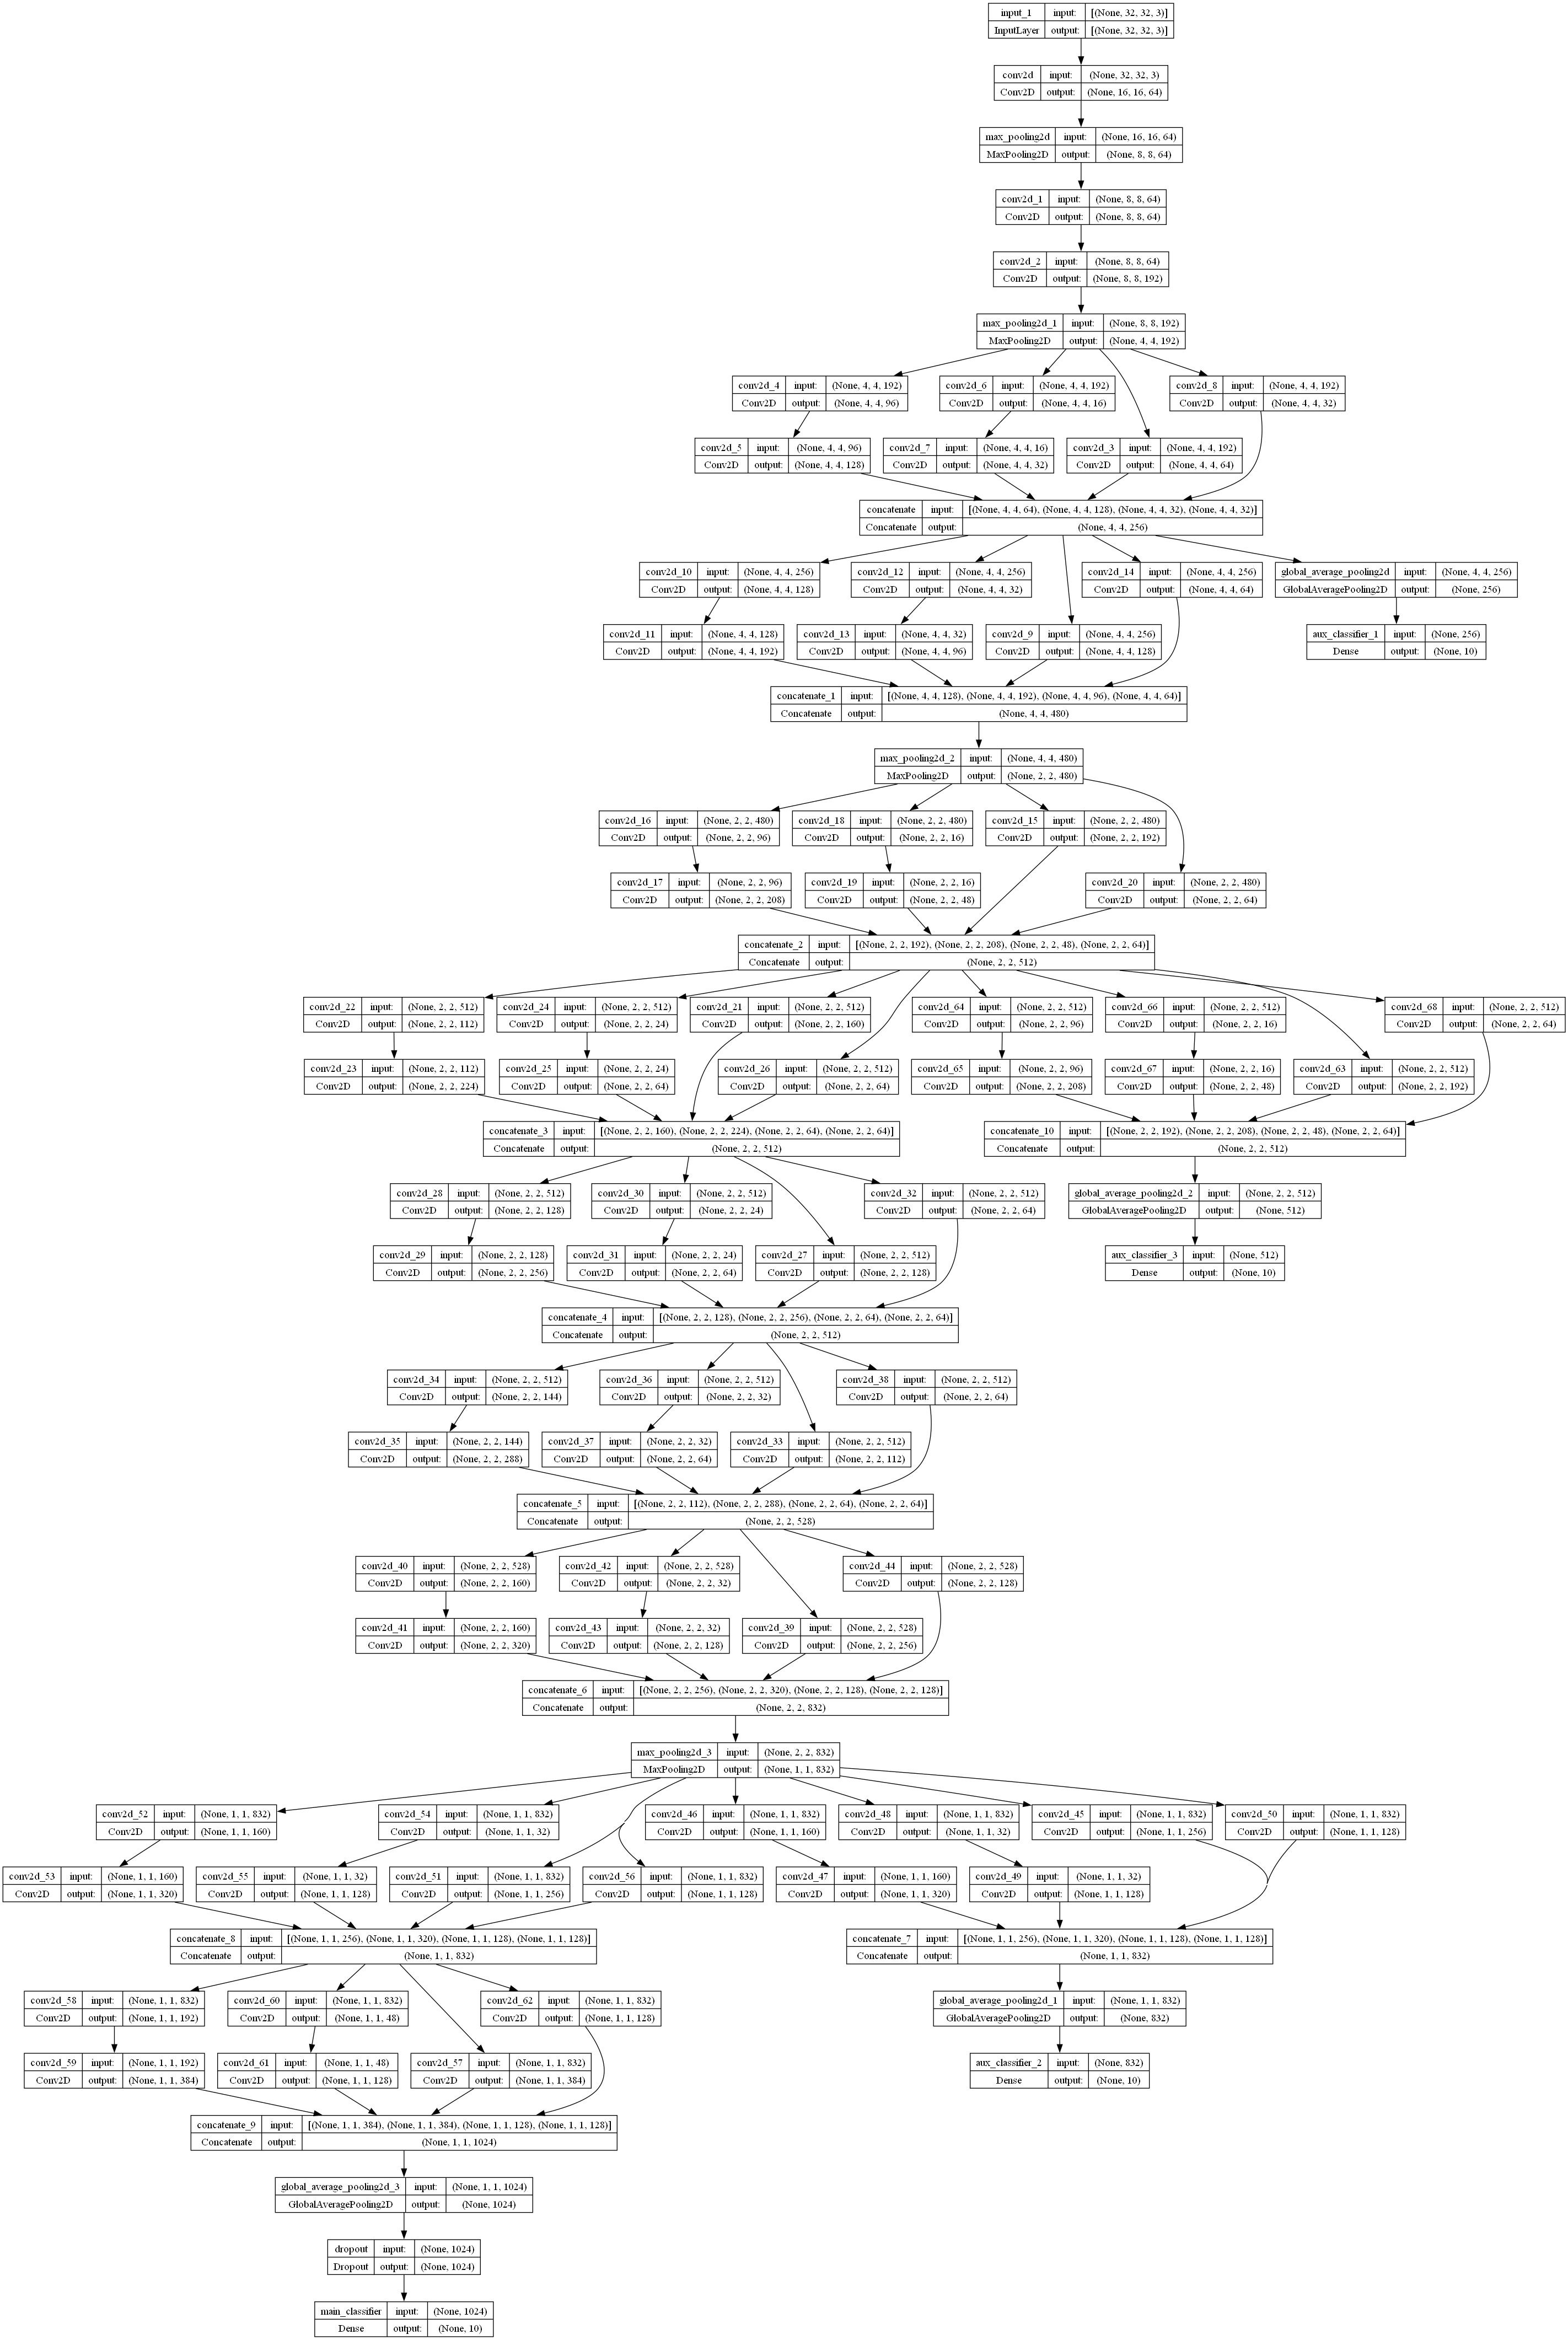

In [10]:
# Plot model architecture
tf.keras.utils.plot_model(model, show_shapes=True, to_file='googlenet_model.png')

In [11]:

# Visualize predictions on test images
def visualize_predictions(model, test_images, num_images=5):
    predictions = model.predict(test_images)
    main_classifier_predictions = predictions[0]
    aux_classifier1_predictions = predictions[1]
    aux_classifier2_predictions = predictions[2]
    aux_classifier3_predictions = predictions[3]

    for i in range(num_images):
        plt.figure(figsize=(16, 4))

        plt.subplot(1, 5, 1)
        plt.imshow(test_images[i])
        plt.title('Input Image')

        plt.subplot(1, 5, 2)
        plt.bar(range(10), main_classifier_predictions[i])
        plt.title('Main Classifier Predictions')

        plt.subplot(1, 5, 3)
        plt.bar(range(10), aux_classifier1_predictions[i])
        plt.title('Aux Classifier 1 Predictions')

        plt.subplot(1, 5, 4)
        plt.bar(range(10), aux_classifier2_predictions[i])
        plt.title('Aux Classifier 2 Predictions')

        plt.subplot(1, 5, 5)
        plt.bar(range(10), aux_classifier3_predictions[i])
        plt.title('Aux Classifier 3 Predictions')

        plt.show()




313/313 [==============================] - 8s 25ms/step


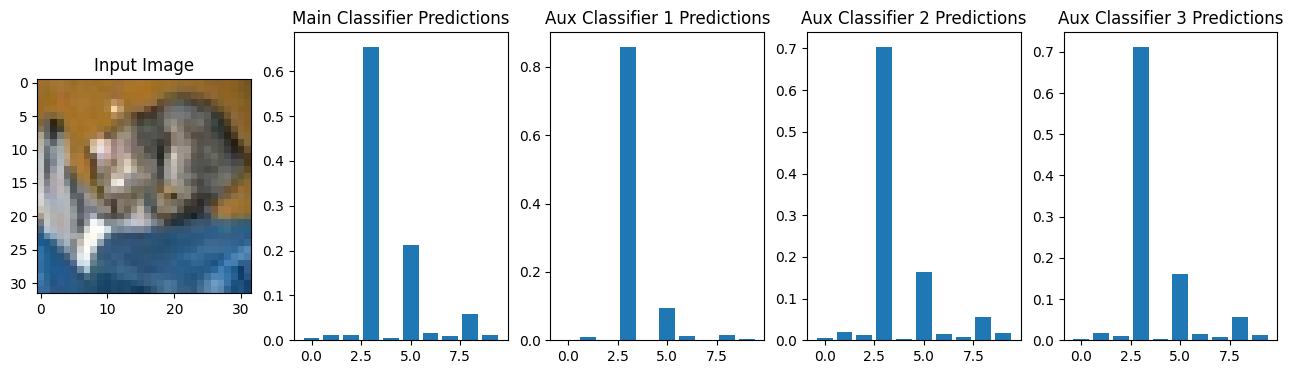

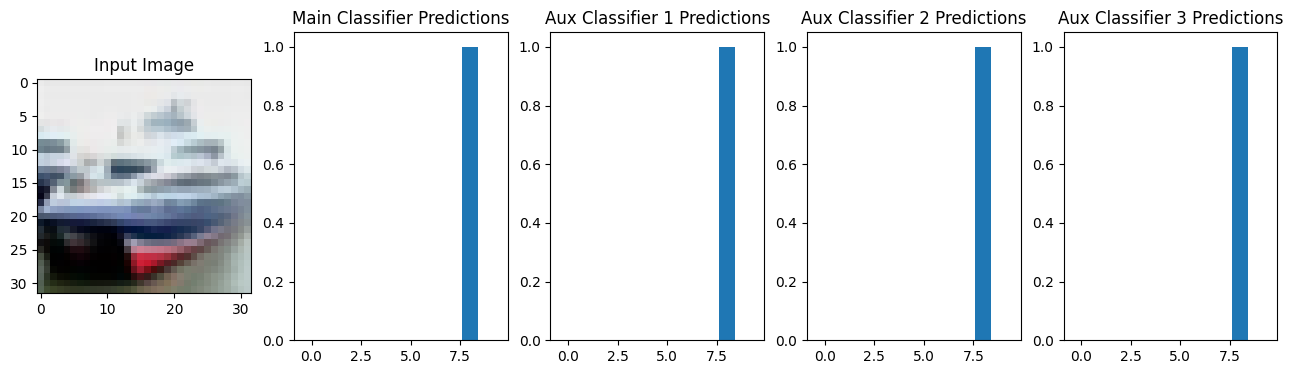

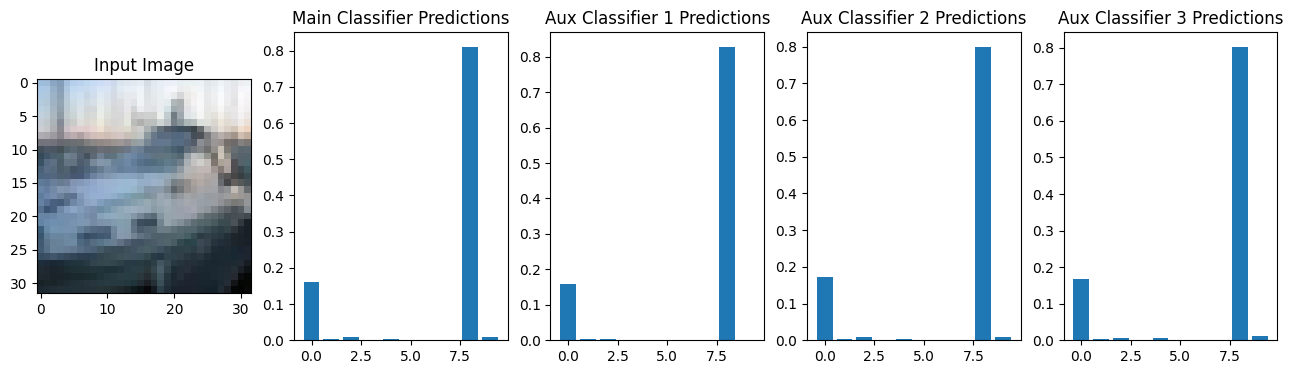

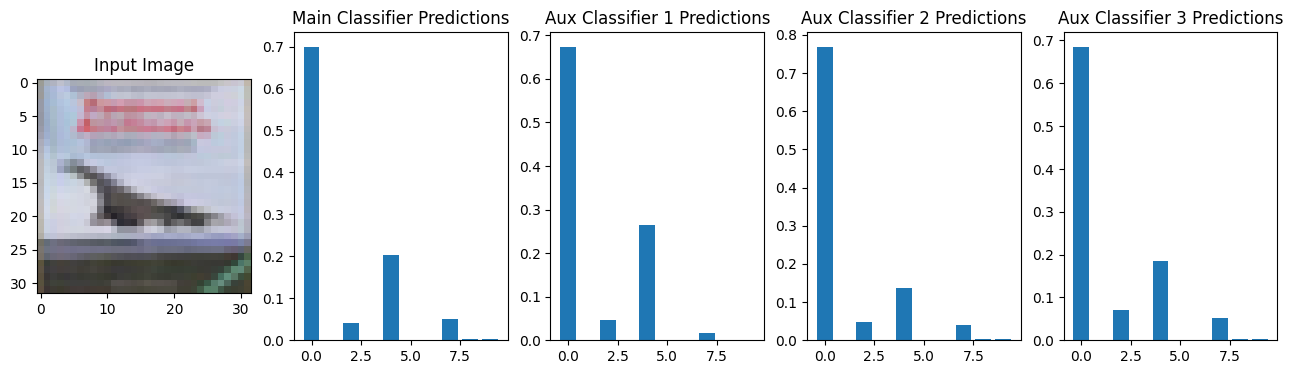

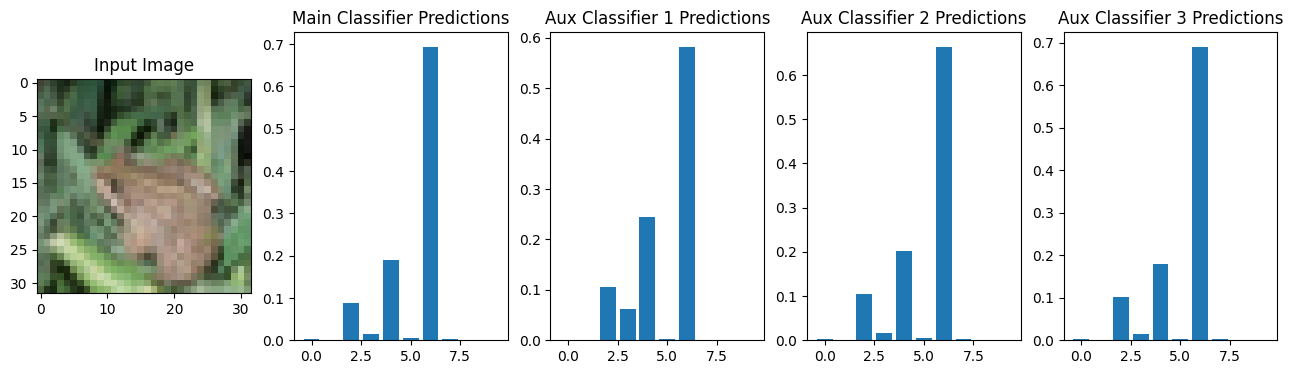

In [20]:
# Visualize predictions on test images
visualize_predictions(model, test_images)

32/32 [==============================] - 2s 30ms/step
Class: airplane


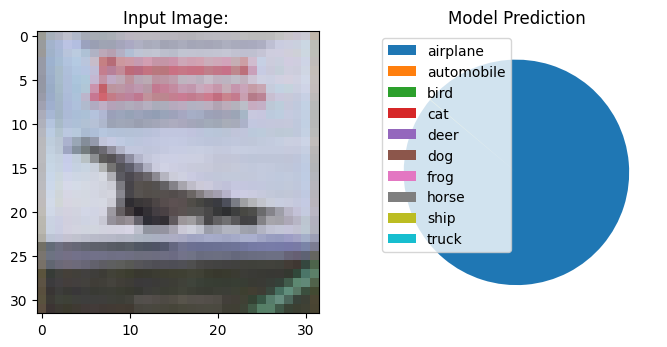

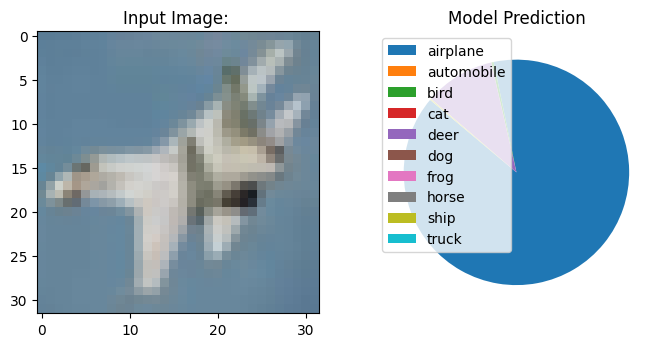

32/32 [==============================] - 1s 28ms/step
Class: automobile


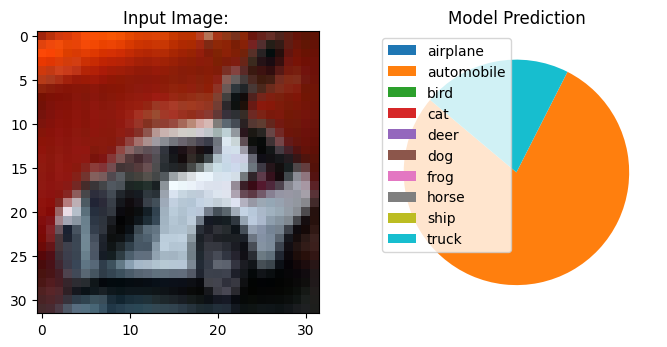

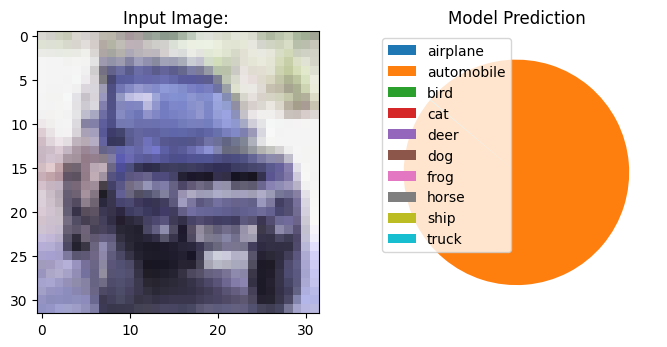

32/32 [==============================] - 1s 23ms/step
Class: bird


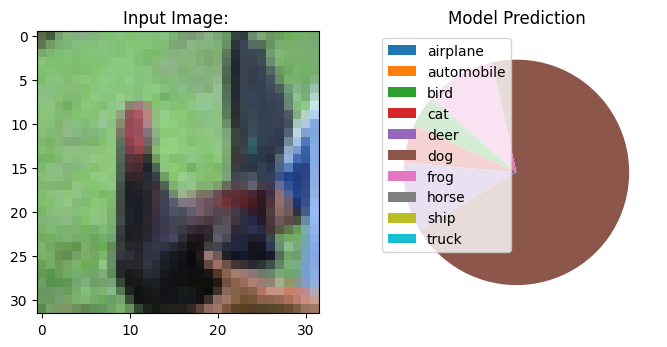

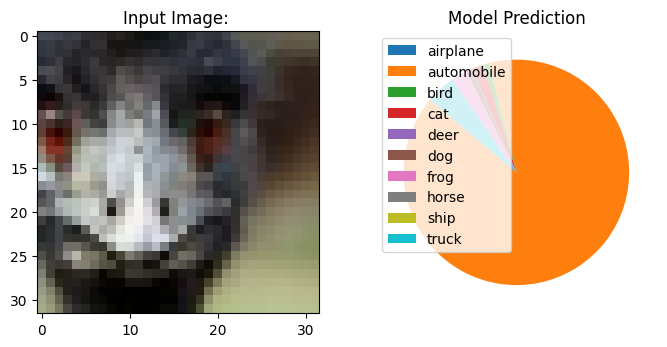

32/32 [==============================] - 1s 25ms/step
Class: cat


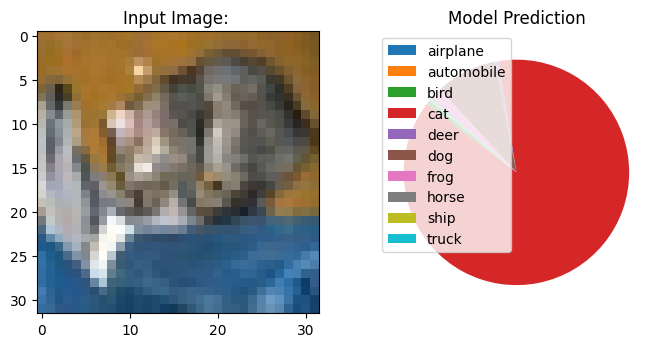

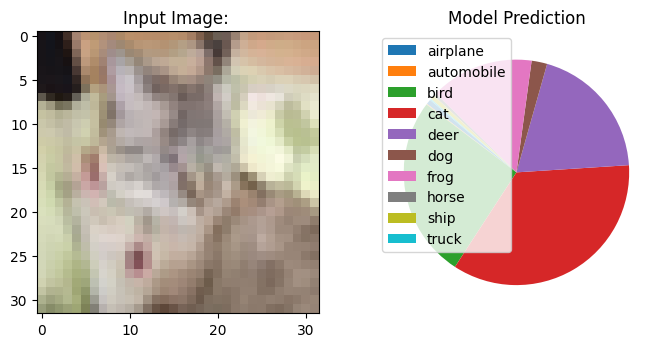

32/32 [==============================] - 1s 25ms/step
Class: deer


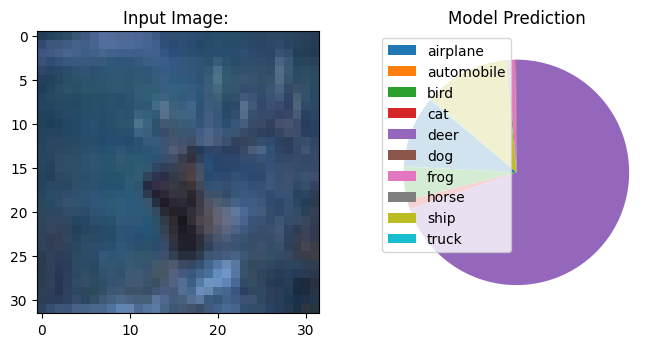

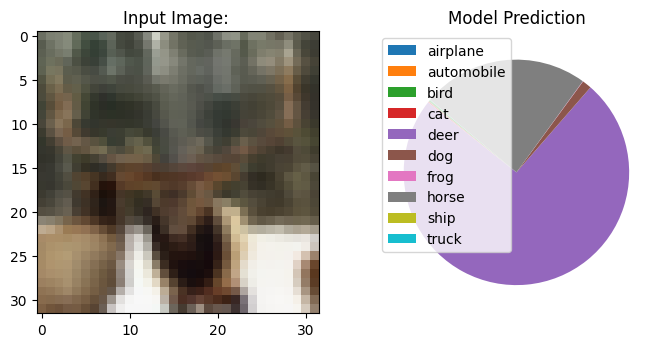

32/32 [==============================] - 1s 23ms/step
Class: dog


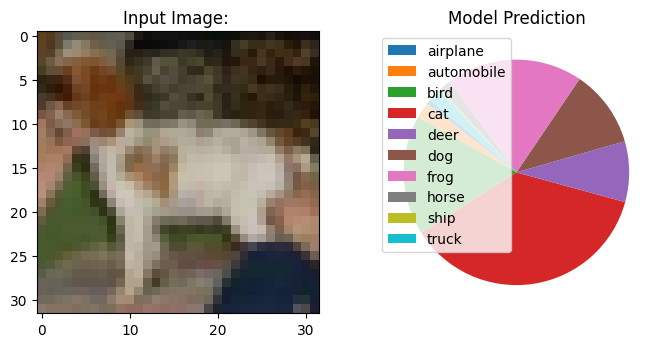

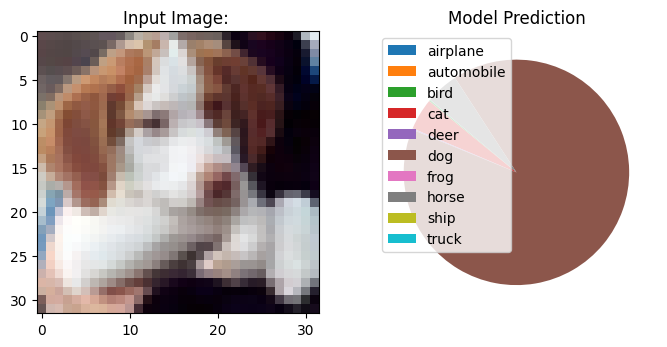

32/32 [==============================] - 1s 25ms/step
Class: frog


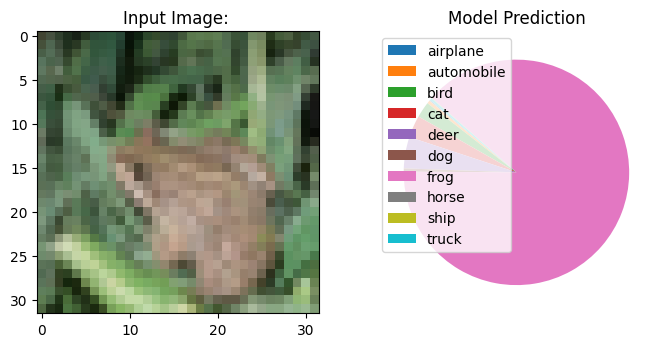

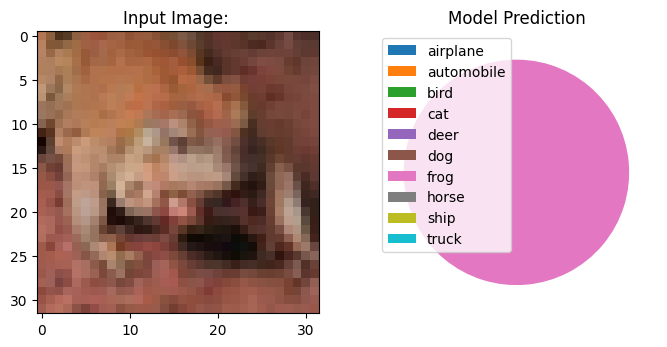

32/32 [==============================] - 1s 24ms/step
Class: horse


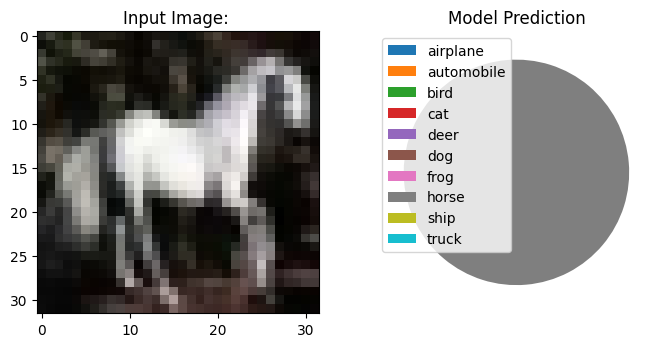

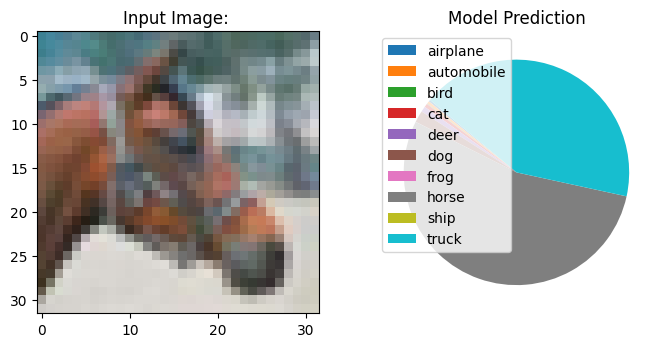

32/32 [==============================] - 1s 26ms/step
Class: ship


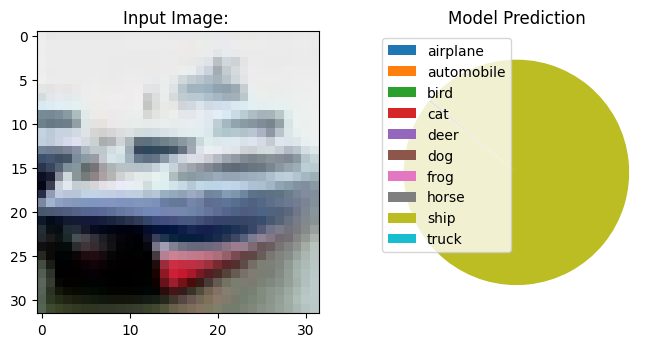

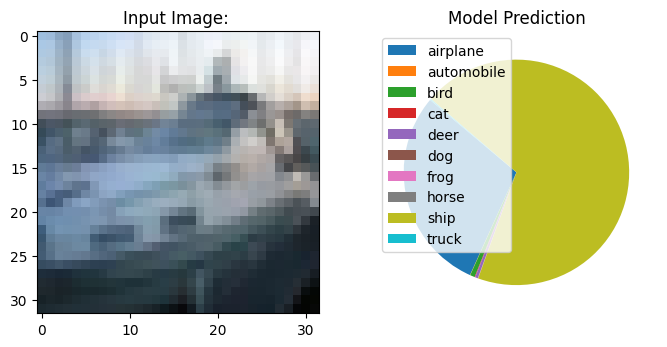

32/32 [==============================] - 1s 25ms/step
Class: truck


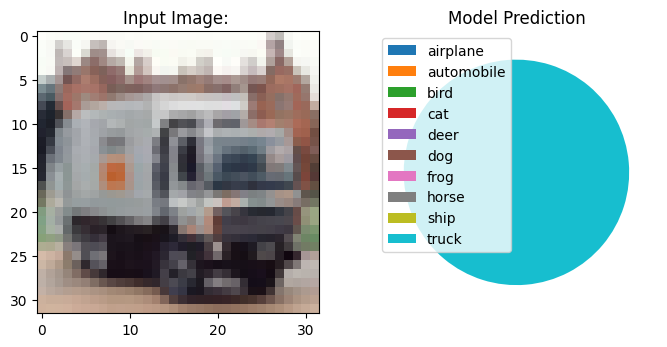

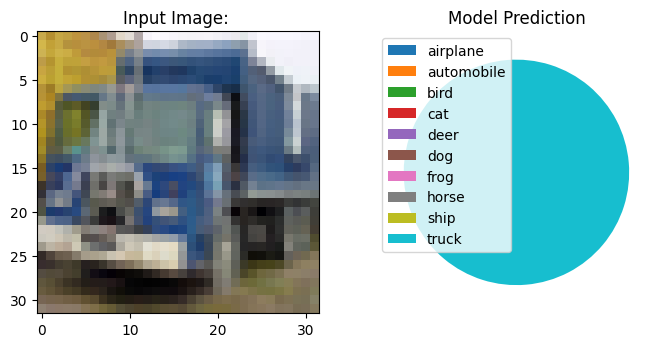

In [12]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Visualize predictions on test images with circular charts
def visualize_test_predictions(model, test_images, test_labels, class_names, num_images_per_class=2):
    num_classes = len(class_names)

    for class_index in range(num_classes):
        class_images = test_images[test_labels[:, class_index] == 1]
        class_labels = test_labels[test_labels[:, class_index] == 1]
        class_predictions = model.predict(class_images)

        print(f"Class: {class_names[class_index]}")
        for i in range(num_images_per_class):
            plt.figure(figsize=(8, 4))

            plt.subplot(1, 2, 1)
            plt.imshow(class_images[i])
            plt.title('Input Image: ')

            plt.subplot(1, 2, 2)
            plt.pie(class_predictions[0][i], startangle=140)
            plt.legend(class_names, loc='upper left')
            plt.title('Model Prediction')

            plt.show()

# Visualize predictions on a few test images
visualize_test_predictions(model, test_images, test_labels, class_names)
